In [1]:
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import seaborn as sns
import xarray as xr
import warnings
warnings.filterwarnings('ignore')
import cmocean
import metpy.calc as mtpy
import xesmf as xe
from math import log10, floor

In [2]:
cd /home/563/slf563/code/gadi/jk72/CMIP_eval/

/home/563/slf563/code/gadi/jk72/CMIP_eval


# Read in initial data

In [3]:
t = pd.DataFrame(index=['Start','End'],columns=['historical','ssp245'])
t.historical = ['1985-01','2014-12']
t.ssp245 = ['2071-01','2100-12']

In [4]:
listname='/g/data/jk72/slf563/CMIP6/CMIP6_query_fast_ice_review.csv'
file_list = pd.read_csv(listname)
file_list= file_list.drop(columns=['sub_experiment_id','Unnamed: 0','index','activity_id','frequency','member_id','time_complete','variable_id'])

In [5]:
fast_ice = xr.open_dataset('/g/data/jk72/slf563/OBS/SIC/fast_ice/fastice_v2.2_persistence.nc')
fast_ice.longitude.values[fast_ice.longitude.values<0] += 360
fast_ice.iceshelfmask.values[fast_ice.latitude.values > -75] = np.nan

### check fast ice data

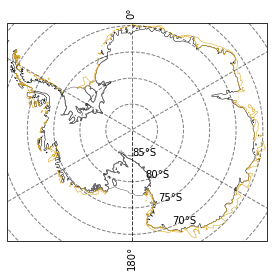

In [6]:
ax = plt.subplot(111, projection=ccrs.SouthPolarStereo())
ax.set_extent([-2690554, 2933445, -2389655, 2309344], ccrs.SouthPolarStereo(central_longitude=0.0))
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=1, color='black', alpha=0.5, linestyle='--')
ax.coastlines(linewidths=[0.5])   

plt.contour(fast_ice.longitude,fast_ice.latitude,fast_ice.iceshelfmask.fillna(0),
           levels=[1],colors=['dimgrey'],linewidths=[0.5],transform=ccrs.PlateCarree())
plt.contour(fast_ice.longitude,fast_ice.latitude,fast_ice.persistence,
           levels=[0.25],colors=['goldenrod'],linewidths=[0.5],transform=ccrs.PlateCarree())

# Functions

In [7]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [8]:
def regrid(ds_in, var, method='bilinear'):
    
    ds_out = xe.util.grid_global(1, 1)
    
    if ('nav_lon' in list(ds_in.coords)) and ('nav_lat' in list(ds_in.coords)):
        ds_in = ds_in.rename({'nav_lat':'lat','nav_lon':'lon'})
    if ('latitude' in list(ds_in.coords)) and ('longitude' in list(ds_in.coords)):
        ds_in = ds_in.rename({'latitude':'lat','longitude':'lon'}) 
    
    regridder = xe.Regridder(ds_in, ds_out, method, periodic=True,ignore_degenerate=True)
    dr_out = regridder(ds_in[var])
    return dr_out

In [9]:
def get_data(var):
    print('Reading {}'.format(var))
    fname = '/g/data/jk72/slf563/CMIP6/CMIP6_fast_ice_ensemble_{}.nc'.format(var)
    if os.path.isfile(fname):
        
        models_all = xr.open_dataset(fname)
    
    else:
    
        models_all= xr.Dataset()
        for scn in ['historical','ssp245']:
            tmp_list = file_list[(file_list.variable==var) & (file_list.experiment_id==scn)]
            for i in range(len(tmp_list)):
                fdir = '{}/*.nc'.format(tmp_list.path.iloc[i])
                data = xr.open_mfdataset(fdir)
                data = data.sel(time=slice(t[scn].Start,t[scn].End))
                data = data.assign_coords({'Model':'{} {}'.format(tmp_list.source_id.iloc[i],tmp_list.variant_label.iloc[i])})
                data = data.assign_coords({'Scenario':tmp_list.experiment_id.iloc[i]})    

                data = regrid(data, var)

                data = data.groupby('time.season').mean()
                
                if var=='siconc' and 'type' in list(data.coords):
                    data = data.drop('type')

                if i == 0: 
                    models = data
                else: 
                    models = xr.concat([models,data],dim='Model')

            if scn == 'historical': 
                models_all = models
            else: 
                models_all = xr.concat([models_all,models],dim='Scenario')
        models_all.to_netcdf(fname)

    return models_all

In [10]:
def plot_properties(sub,data,title,levels,cmap='viridis',supress_alpha='No',cbar_plot=False):
    abc = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    ax = plt.subplot(sub[0],sub[1],sub[2], projection=ccrs.SouthPolarStereo())
    ax.set_extent([-2690554, 2933445, -2389655, 2309344], ccrs.SouthPolarStereo(central_longitude=0.0))
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='black', alpha=0.5, linestyle='--')
    
    
    p = plt.contourf(data.lon,data.lat,data,
                    cmap=cmap,
                    transform=ccrs.PlateCarree(),
                    levels=levels,
                    add_colorbar=cbar_plot,
                    extend='both',
                    );

    plt.contour(fast_ice.longitude,fast_ice.latitude,fast_ice.iceshelfmask.fillna(0),
               levels=[1],colors=['black'],linewidths=[0.5],transform=ccrs.PlateCarree())
    #plt.contour(fast_ice.longitude,fast_ice.latitude,fast_ice.groundedmask.fillna(0),
    #           levels=[1],colors=['black'],linewidths=[0.8],transform=ccrs.PlateCarree())
    plt.contour(fast_ice.longitude,fast_ice.latitude,fast_ice.persistence,
               levels=[0.25],colors=['goldenrod'],linewidths=[0.5],transform=ccrs.PlateCarree())
    ax.coastlines(linewidths=[0.5])
    
    plt.title('');
    if supress_alpha == 'Yes': 
        plt.title('{}'.format(title),loc='center');    
    else: 
        plt.title('{}) {}'.format(abc[sub[2]-1],title),loc='left');
    return(p)

In [11]:
def plot_CMIP(models,title,units,levels,cmap2="RdBu"):
          
    fig = plt.figure(figsize=(11,3))

    p2 = plot_properties([1,4,1],
                         models.sel(Scenario='ssp245',season='DJF').mean('Model')-models.sel(Scenario='historical',season='DJF').mean('Model'),
                         'DJF',levels,cmap=cmap2);
    p2 = plot_properties([1,4,2],
                         models.sel(Scenario='ssp245',season='MAM').mean('Model')-models.sel(Scenario='historical',season='MAM').mean('Model'),
                         'MAM',levels,cmap=cmap2);
    p2 = plot_properties([1,4,3],
                         models.sel(Scenario='ssp245',season='JJA').mean('Model')-models.sel(Scenario='historical',season='JJA').mean('Model'),
                         'JJA',levels,cmap=cmap2);
    p2 = plot_properties([1,4,4],
                         models.sel(Scenario='ssp245',season='SON').mean('Model')-models.sel(Scenario='historical',season='SON').mean('Model'),
                         'SON',levels,cmap=cmap2);
    plt.suptitle(title,y=0.92,size=14)

    cax = plt.axes([0.88, 0.15, 0.03, 0.6])
    plt.colorbar(p2,cax=cax,label=units,);
    plt.subplots_adjust(right=0.87,left=0.02,bottom=0.02,wspace=0.02)
    

In [12]:
def round_sig(x, sig=2):
    return np.round(x, sig-int(floor(log10(abs(x))))-1)

In [13]:
def calc_means(means,data,var):
    for sea in ['DJF','MAM','JJA','SON']:
        means.loc[var][sea] = round_sig((data[var].sel(Scenario='ssp245',season=sea).mean('Model') - 
        data[var].sel(Scenario='historical',season=sea).mean('Model')*weights).mean().values,3)
    return means

# Read in CMIP6 data 
Either generate data for the first time or read in the previously generated files 

In [14]:
models_tas = get_data('tas')
models_tasmin = get_data('tasmin')
models_tasmax = get_data('tasmax')

models_pr = get_data('pr')
models_prsn = get_data('prsn')
models_prl = models_pr.pr - models_prsn.prsn # get liquid only 
models_prl = models_prl.rename('prl').to_dataset()
models_prsn = models_prsn * 60 * 60 * 24 # kg/m2/s to kg/m2/day 
models_prl = models_prl * 60 * 60 * 24 # kg/m2/s to kg/m2/day
ndays = xr.DataArray([90,91,92,92],dims='season')
ndays.assign_coords({'season':models_prsn.season.values})
models_prsn = models_prsn*ndays # kg/m2/day to kg/m2/season
models_prl = models_prl*ndays # kg/m2/day to kg/m2/season

models_psl = get_data('psl')
models_psl = models_psl/100 # Pa to hPa

models_rsds = get_data('rsds')

models_uas = get_data('uas')
models_vas = get_data('vas')
models_uas['uas']  = models_uas.uas.assign_attrs({'units':'m s-1'})
models_vas['vas']  = models_vas.vas.assign_attrs({'units':'m s-1'})
models_wspd = mtpy.wind_speed(models_uas.uas, models_vas.vas)
models_wspd = models_wspd.rename('wspd').to_dataset()

models_tos = get_data('tos')
models_siconc = get_data('siconc')
models_sithick = get_data('sithick')


Reading tas
Reading tasmin
Reading tasmax
Reading pr
Reading prsn
Reading psl
Reading rsds
Reading uas
Reading vas
Reading tos
Reading siconc
Reading sithick


# Calc means
- Inititialise array for means 
- Regrid fast ice to same grid as CMIP6 data
- Calc means

In [15]:
varlist = ['tas','tasmin','tasmax','prl','prsn','rsds','psl','uas','vas','wspd','tos','sithick','siconc']

In [16]:
means = pd.DataFrame(index=varlist,columns=['DJF','del1','MAM','del2','JJA','del3','SON'])
means['del1'] = '&'
means['del2'] = '&'
means['del3'] = '&'

In [17]:
new_fast = regrid(fast_ice,'persistence')
weights = new_fast.copy()
weights = weights.where(weights>0.0,np.nan)
weights = weights.where(np.isnan(weights),1)

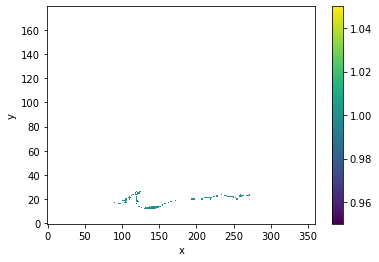

In [18]:
weights.plot()

In [19]:
means = calc_means(means,models_tas,'tas')
means = calc_means(means,models_tasmin,'tasmin')
means = calc_means(means,models_tasmax,'tasmax')
means = calc_means(means,models_prsn,'prsn')
means = calc_means(means,models_prl,'prl')
means = calc_means(means,models_psl,'psl')
means = calc_means(means,models_rsds,'rsds')
means = calc_means(means,models_uas,'uas')
means = calc_means(means,models_vas,'vas')
means = calc_means(means,models_wspd,'wspd')
means = calc_means(means,models_tos,'tos')
means = calc_means(means,models_sithick,'sithick')
means = calc_means(means,models_siconc,'siconc')
means.to_csv('cmip6_fast_ice_means.csv')

# Make plots

### Surface temp (mean, min, max)

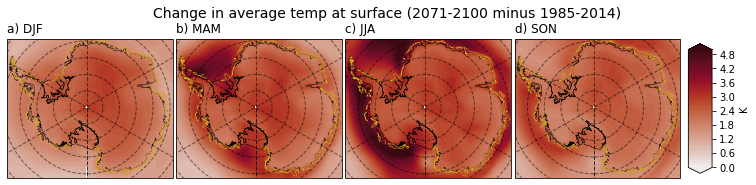

In [20]:
p = plot_CMIP(models_tas.tas,'Change in average temp at surface (2071-2100 minus 1985-2014)','K',
              levels=np.arange(0,5.1,0.1),cmap2=truncate_colormap(cmocean.cm.balance,0.5,1))
plt.savefig('tas.pdf')

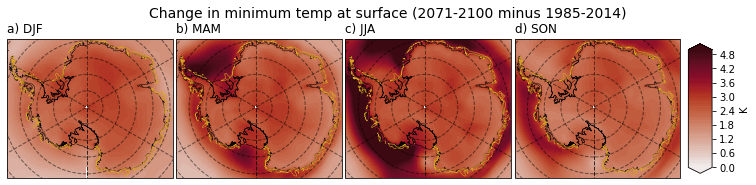

In [21]:
p = plot_CMIP(models_tasmin.tasmin,'Change in minimum temp at surface (2071-2100 minus 1985-2014)','K',
              levels=np.arange(0,5.1,0.1),cmap2=truncate_colormap(cmocean.cm.balance,0.5,1))
plt.savefig('tasmin.pdf')

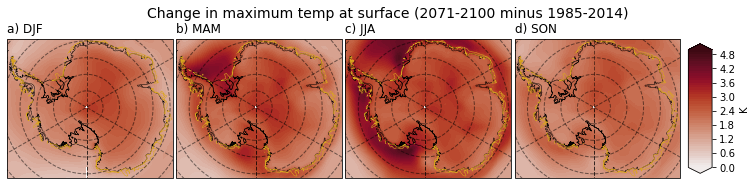

In [22]:
p = plot_CMIP(models_tasmax.tasmax,'Change in maximum temp at surface (2071-2100 minus 1985-2014)','K',
              levels=np.arange(0,5.1,0.1),cmap2=truncate_colormap(cmocean.cm.balance,0.5,1))
plt.savefig('tasmax.pdf')

### Liquid and ice precip

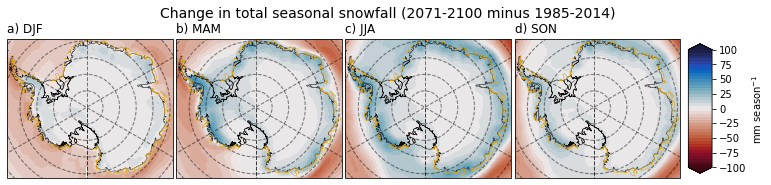

In [23]:
p = plot_CMIP(models_prsn.prsn,'Change in total seasonal snowfall (2071-2100 minus 1985-2014)','mm season$^{-1}$',
              levels=np.arange(-100,105,5),cmap2=cmocean.cm.balance_r)
plt.savefig('prsn.pdf')

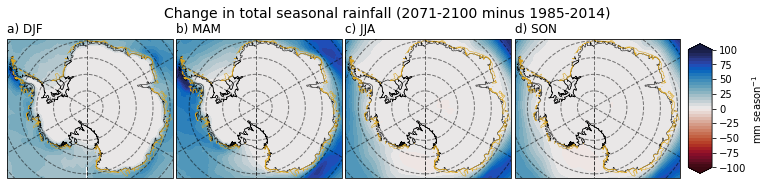

In [24]:
p = plot_CMIP(models_prl.prl,'Change in total seasonal rainfall (2071-2100 minus 1985-2014)','mm season$^{-1}$',
              levels=np.arange(-100,105,5),cmap2=cmocean.cm.balance_r)
plt.savefig('prl.pdf')

### MSLP

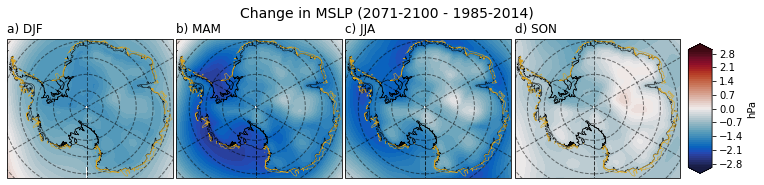

In [25]:
p = plot_CMIP(models_psl.psl,'Change in MSLP (2071-2100 - 1985-2014)','hPa',
              levels=np.arange(-3,3.1,0.1),cmap2=cmocean.cm.balance)
plt.savefig('psl.pdf')

### Surface short wave downwelling raditaion

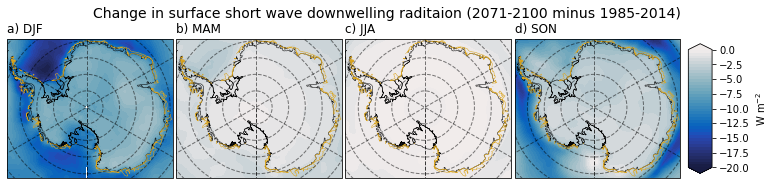

In [26]:
p = plot_CMIP(models_rsds.rsds,'Change in surface short wave downwelling raditaion (2071-2100 minus 1985-2014)','W m$^{-2}$',
              levels=np.arange(-20,0.5,0.5),cmap2=truncate_colormap(cmocean.cm.balance,0,0.5))
plt.savefig('rsds.pdf')

### Wind 

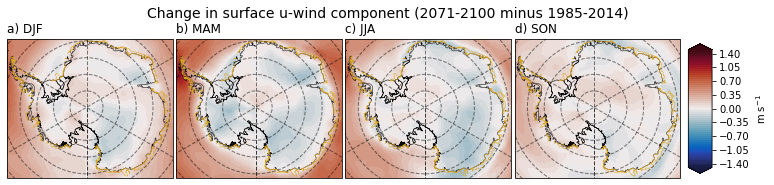

In [28]:
p = plot_CMIP(models_uas.uas,'Change in surface u-wind component (2071-2100 minus 1985-2014)','m s${^{-1}}$',
              levels=np.arange(-1.5,1.55,0.05),cmap2=cmocean.cm.balance)
plt.savefig('uas.pdf')

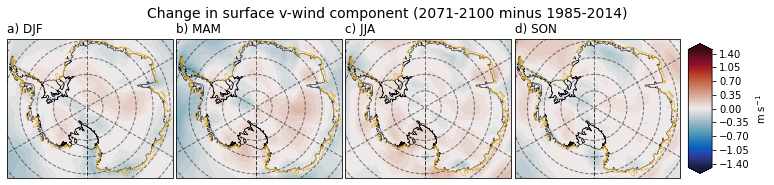

In [29]:
p = plot_CMIP(models_vas.vas,'Change in surface v-wind component (2071-2100 minus 1985-2014)','m s${^{-1}}$',
              levels=np.arange(-1.5,1.55,0.05),cmap2=cmocean.cm.balance)
plt.savefig('vas.pdf')

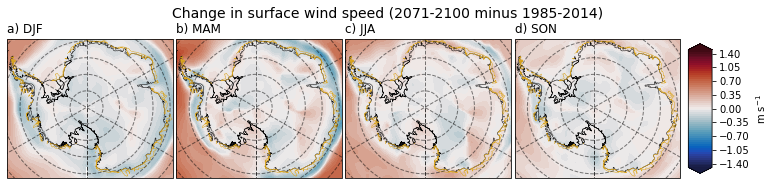

In [30]:
p = plot_CMIP(models_wspd.wspd,'Change in surface wind speed (2071-2100 minus 1985-2014)','m s${^{-1}}$',
              levels=np.arange(-1.5,1.55,0.05),cmap2=cmocean.cm.balance)
plt.savefig('wspd.pdf')

### SSTs

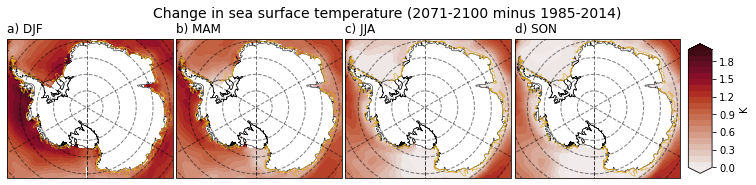

In [31]:
p = plot_CMIP(models_tos.tos,'Change in sea surface temperature (2071-2100 minus 1985-2014)','K',
              levels=np.arange(0,2.1,0.1),cmap2=truncate_colormap(cmocean.cm.balance,0.5,1))
plt.savefig('tos.pdf')

### Sea ice conc

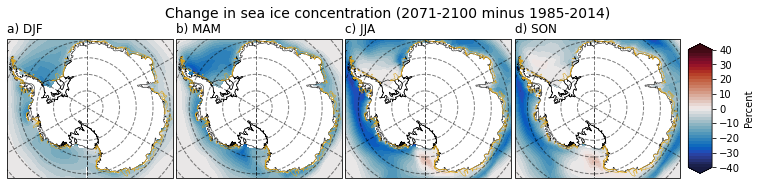

In [32]:
p = plot_CMIP(models_siconc.siconc,'Change in sea ice concentration (2071-2100 minus 1985-2014)','Percent',
              levels=np.arange(-40,42,2),cmap2=cmocean.cm.balance)
plt.savefig('siconc.pdf')

### Sea ice thickness

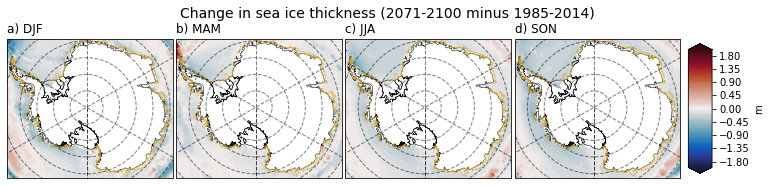

In [33]:
p = plot_CMIP(models_sithick.sithick,'Change in sea ice thickness (2071-2100 minus 1985-2014)','m',
              levels=np.arange(-2,2.05,0.05),cmap2=cmocean.cm.balance)
plt.savefig('sithick.pdf')